Available labels:
 ['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead shark', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'American robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'American dipper', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'fire salamander', 'smooth newt', 'newt', 'spotted salamander', 'axolotl', 'American bullfrog', 'tree frog', 'tailed frog', 'loggerhead sea turtle', 'leatherback sea turtle', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'green iguana', 'Carolina anole', 'desert grassland whiptail lizard', 'agama', 'frilled-necked lizard', 'alligator lizard', 'Gila monster', 'European green lizard', 'chameleon', 'Komodo dragon', 'Nile crocodile', 'American alligator', 'triceratops', 'worm snake', 'ring-necked snake', 'eastern hog-nosed snake', 'smooth green snake', 'kingsnake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constricto

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth



Top 5 predictions:
umbrella 0.9973933696746826
parachute 0.0009347004815936089
hook 0.000553132442291826
lampshade 0.00020475898054428399
table lamp 0.0001582660770509392


100%|██████████| 20.5M/20.5M [00:00<00:00, 101MB/s]


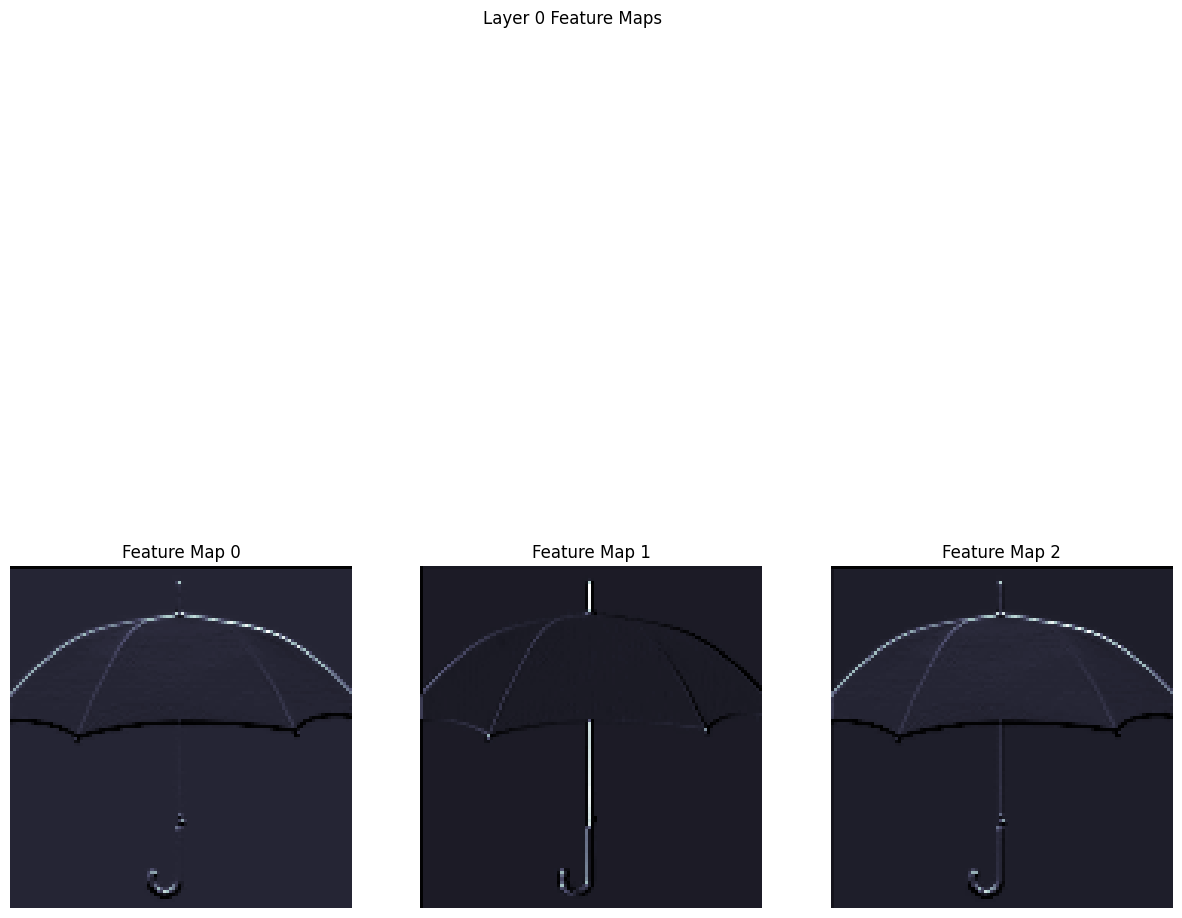

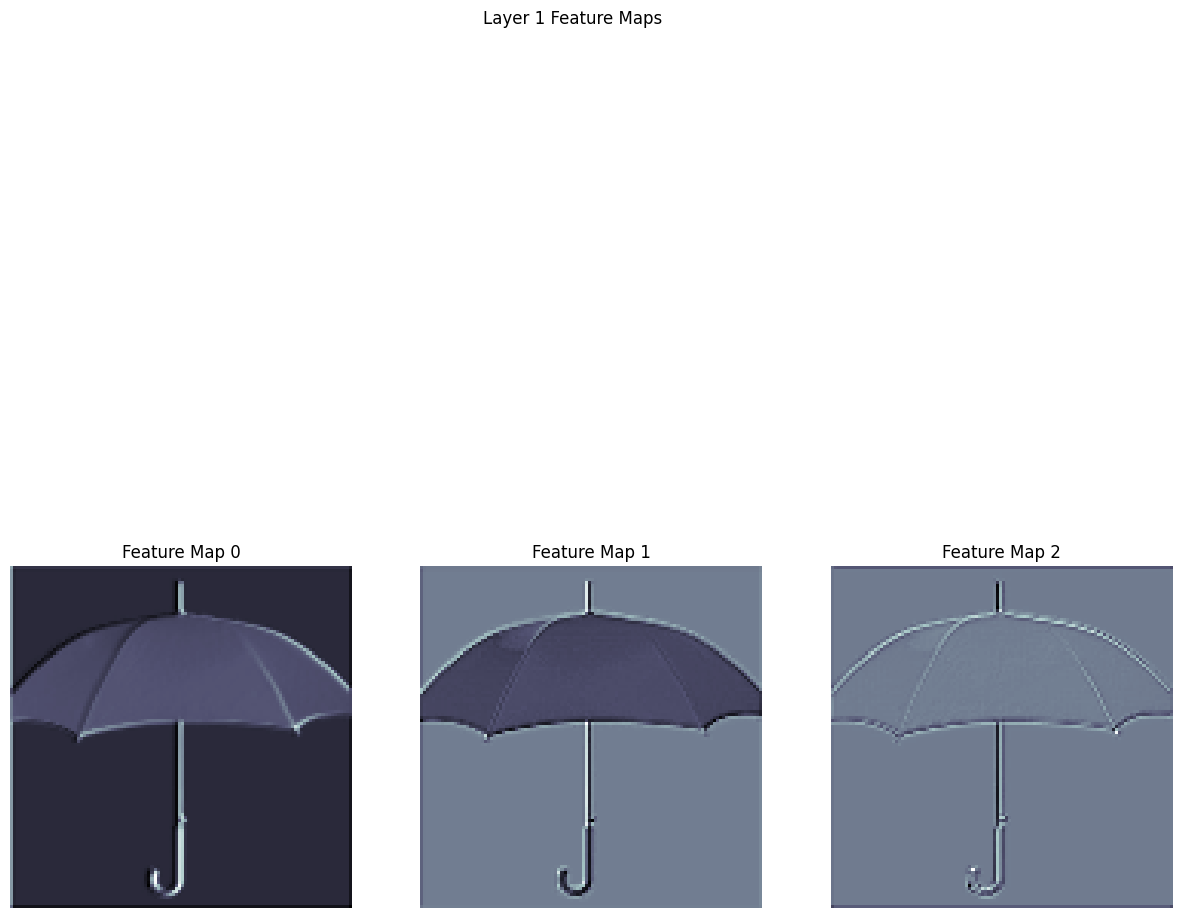

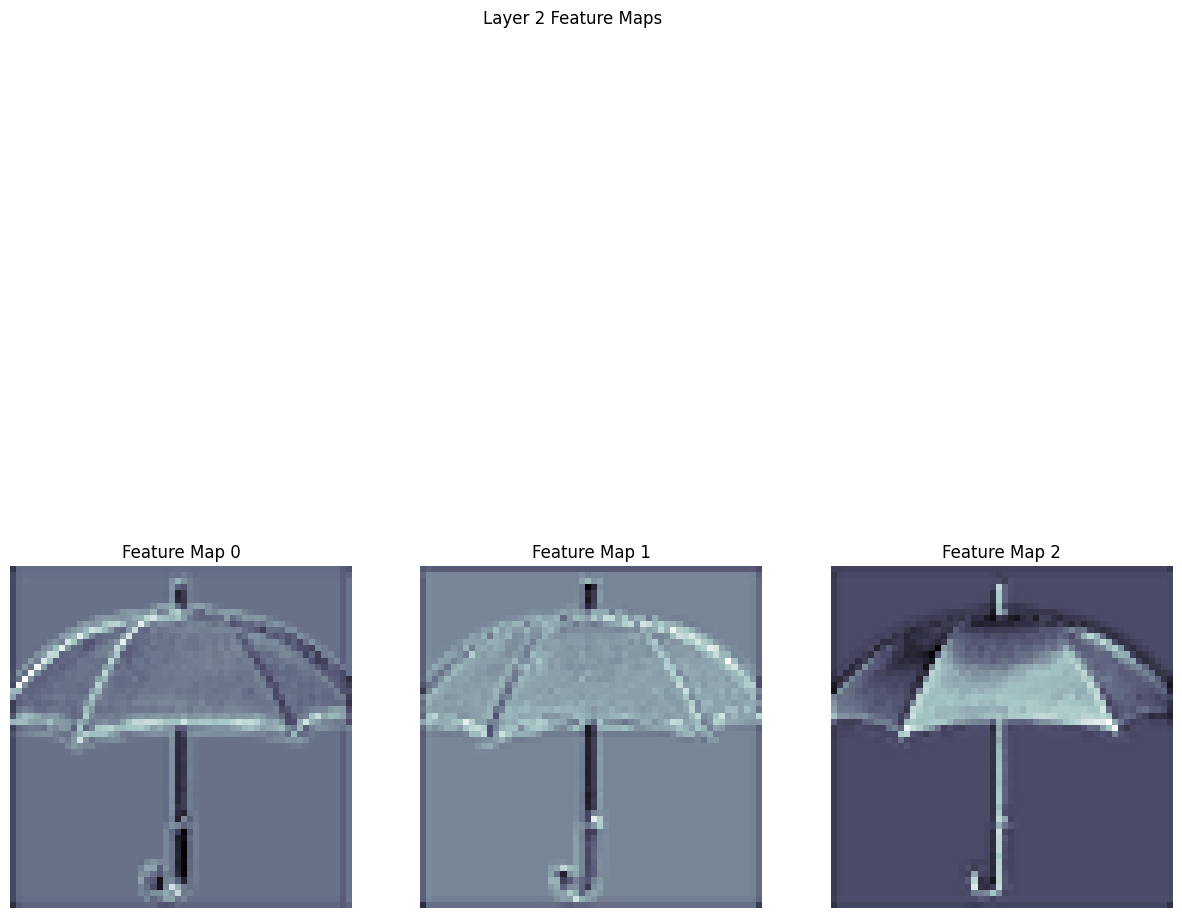

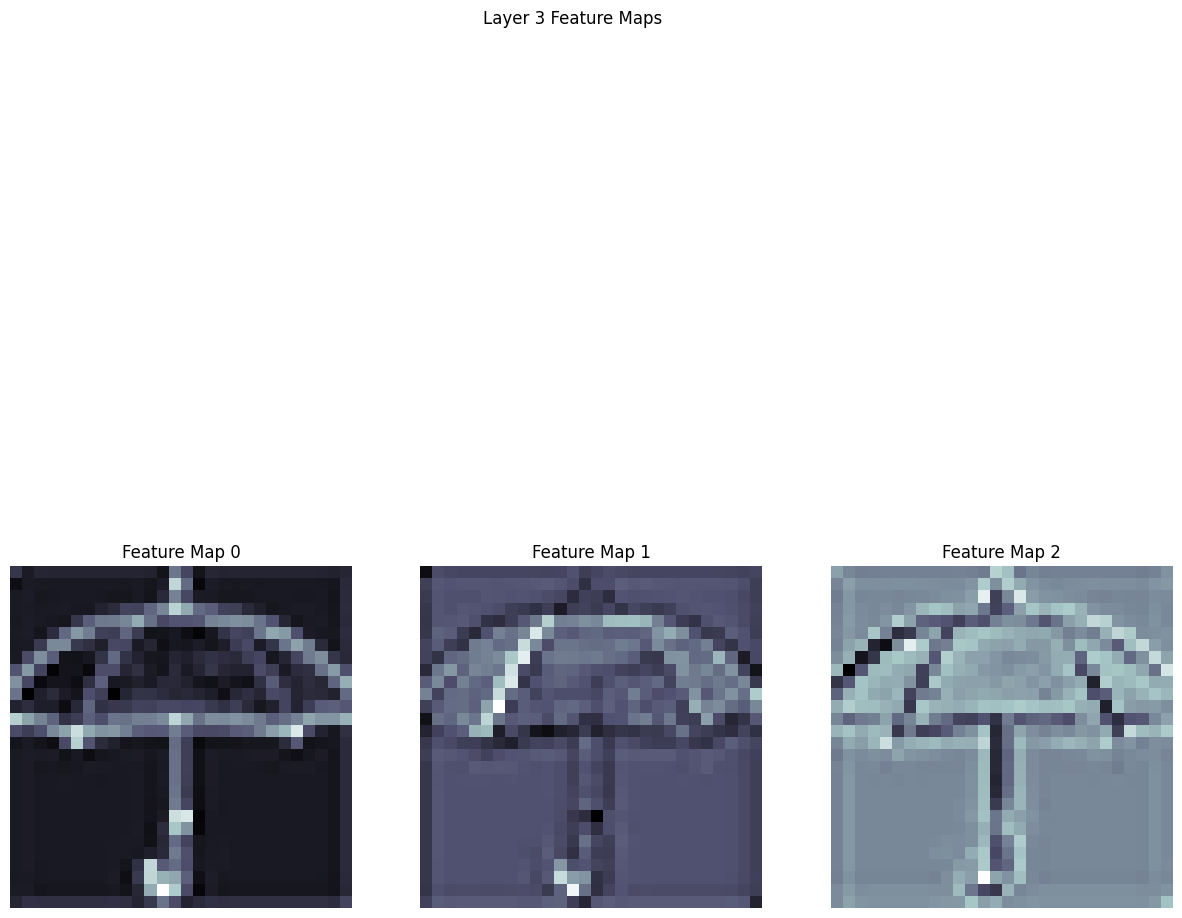

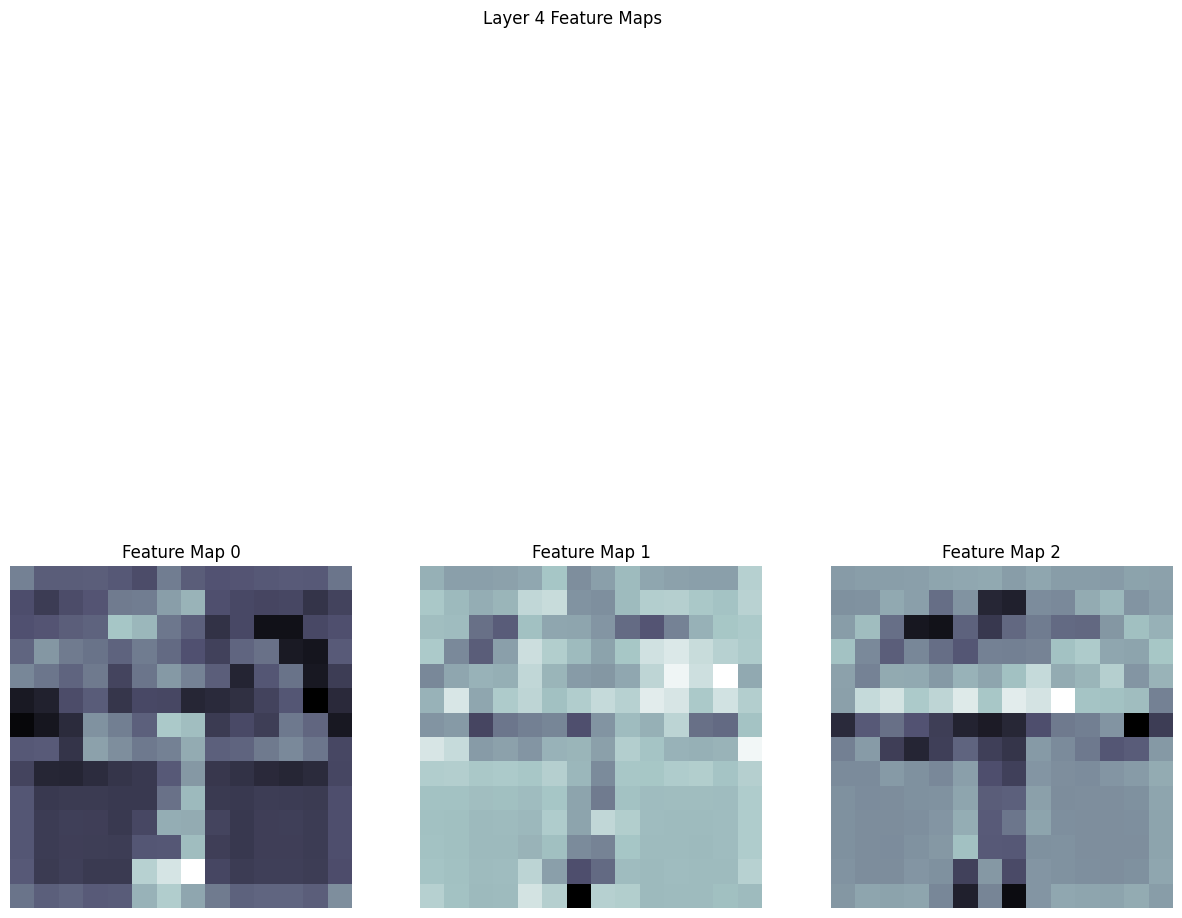

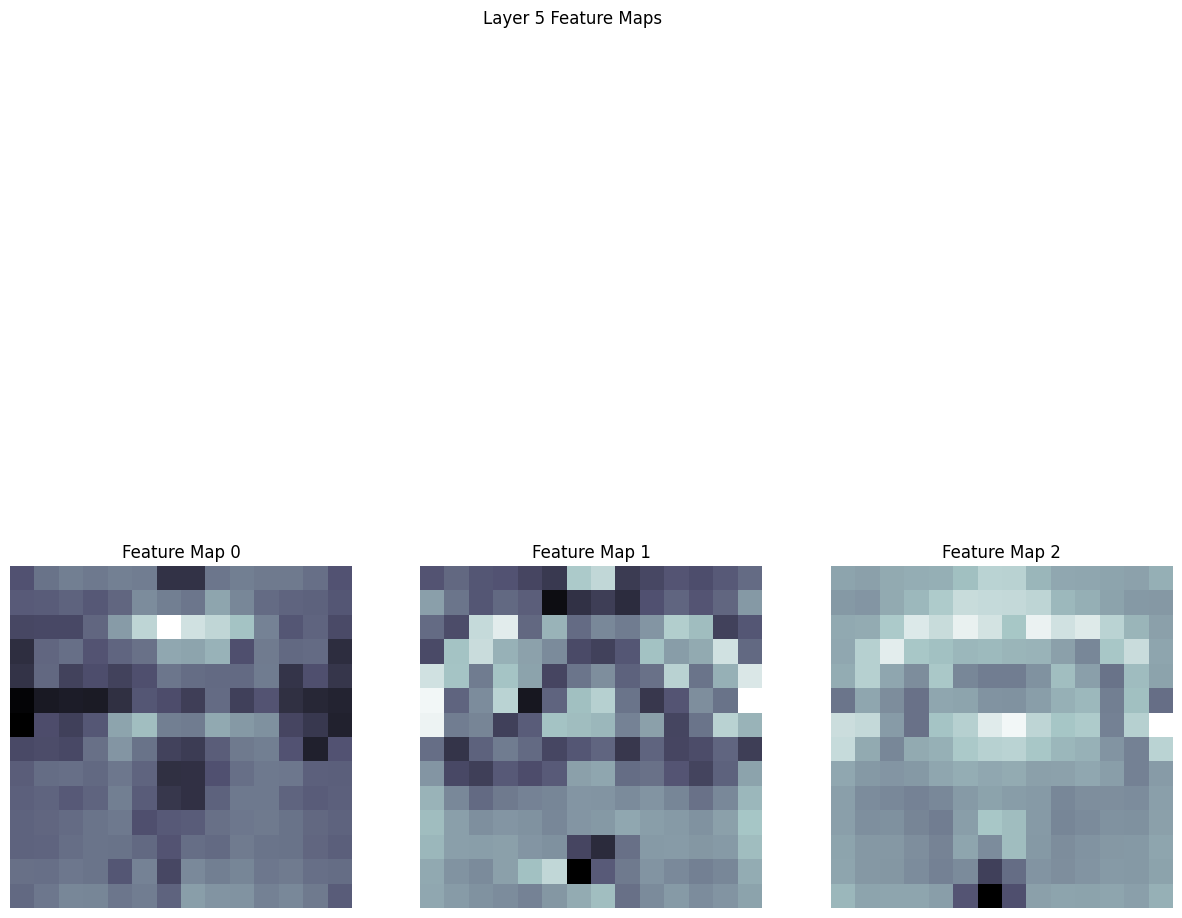

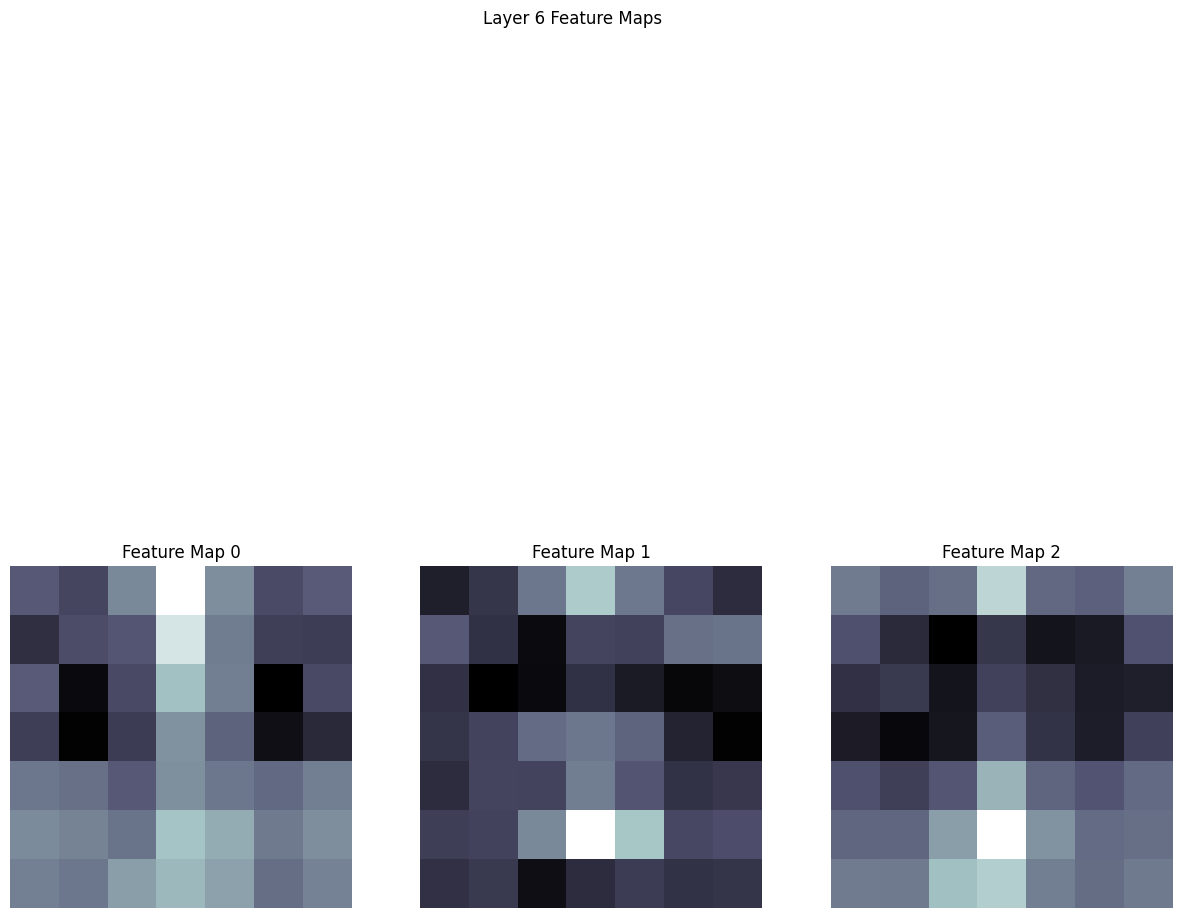

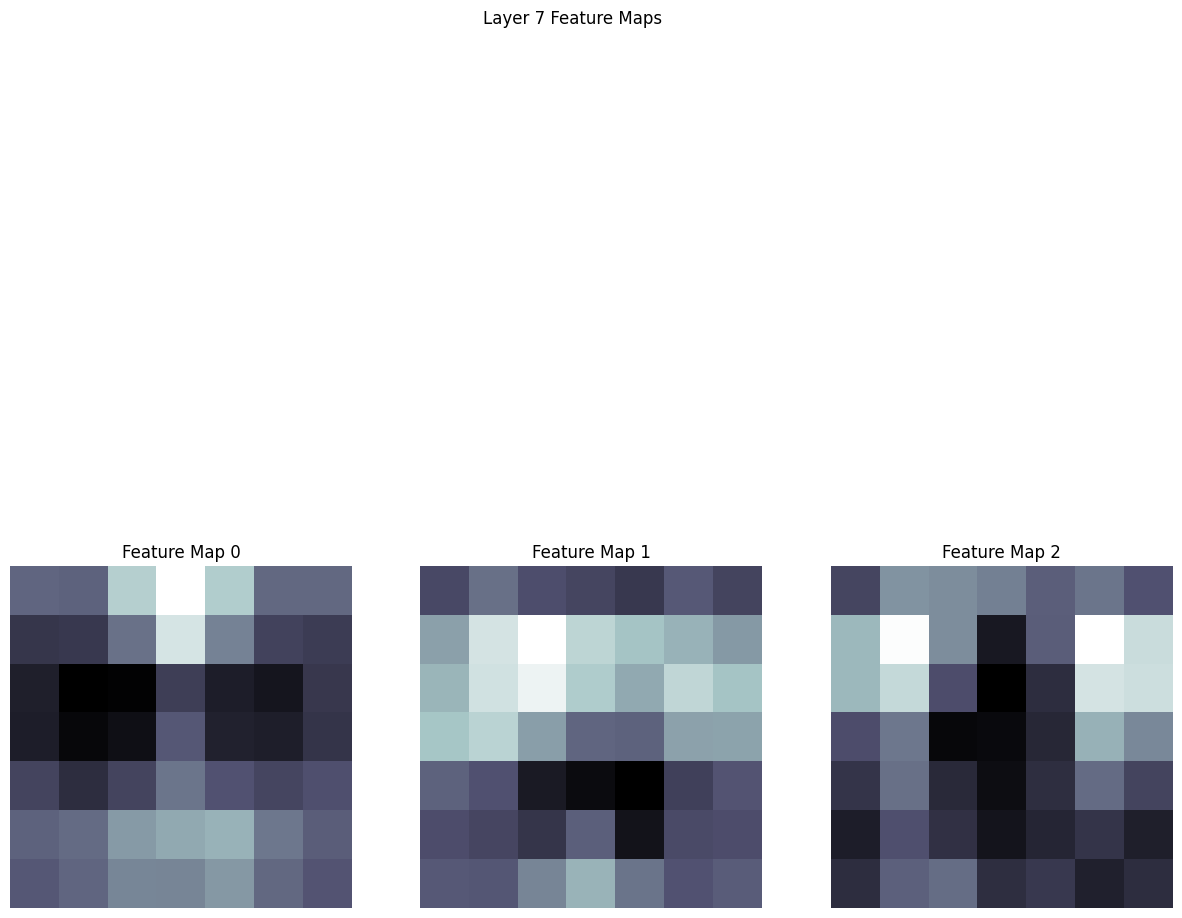

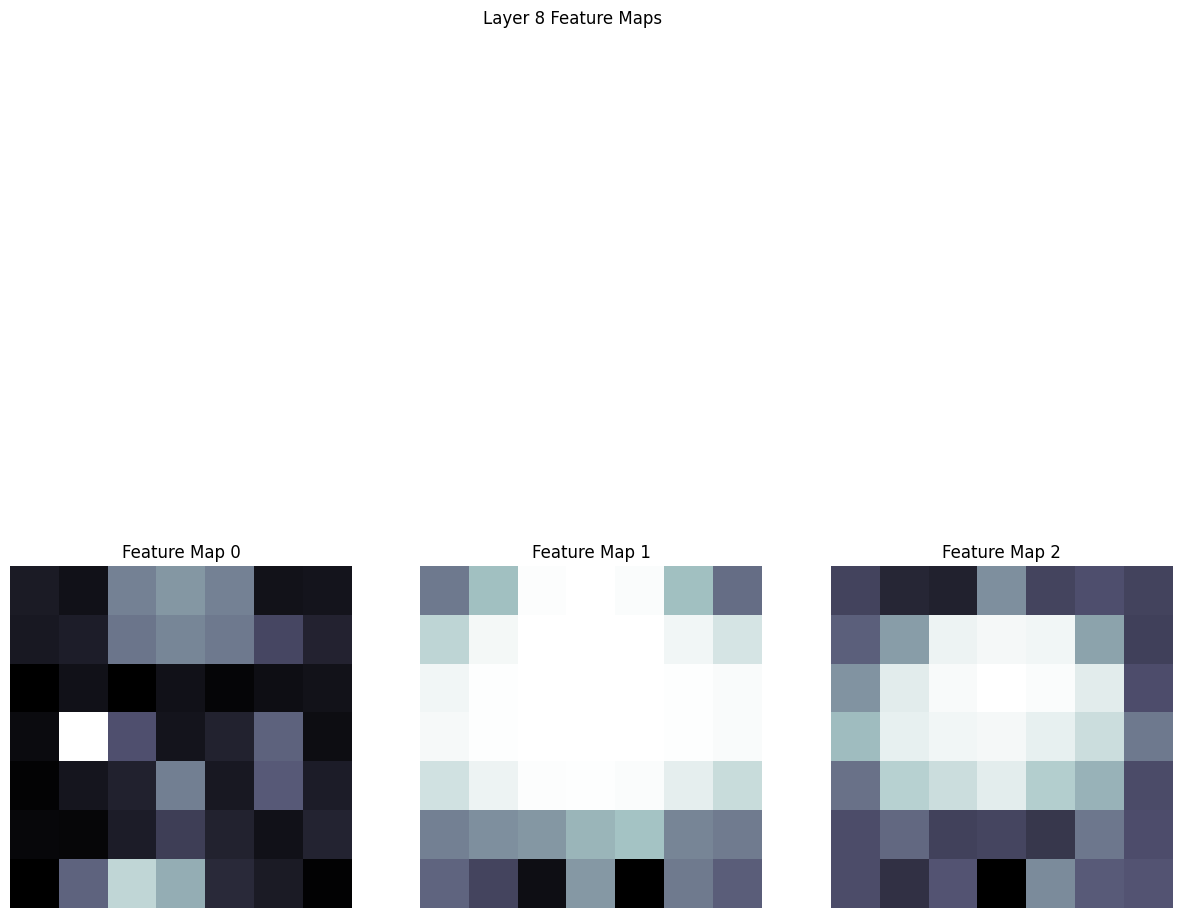

In [4]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import json
import requests

LABELS_URL = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
response = requests.get(LABELS_URL)
labels = json.loads(response.text)
print(f"Available labels:\n {labels}")

model = models.resnet50(pretrained=True)
model.eval()  # Set the model to evaluation mode

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_path = "umbrella.jpg"
input_image = Image.open(image_path).convert('RGB')
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
input_batch = input_batch.to(device)

with torch.no_grad():
    output = model(input_batch)

probabilities = torch.nn.functional.softmax(output[0], dim=0)

top5_prob, top5_catid = torch.topk(probabilities, 5)
print("\nTop 5 predictions:")
for i in range(5):
    print(labels[top5_catid[i]], top5_prob[i].item())

efficientnet_model = models.efficientnet_b0(pretrained=True)
efficientnet_model.eval()

activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

for idx, layer in enumerate(efficientnet_model.features):
    layer.register_forward_hook(get_activation(f"layer_{idx}"))

with torch.no_grad():
    output = efficientnet_model(input_batch)

def plot_activations(layer_activations, layer_num):
    num_feature_maps = min(3, layer_activations.shape[0])
    fig, axes = plt.subplots(1, num_feature_maps, figsize=(15, 15))
    for i in range(num_feature_maps):
        axes[i].imshow(layer_activations[i].cpu(), cmap='bone')
        axes[i].axis('off')
        axes[i].set_title(f'Feature Map {i}')
    plt.suptitle(f'Layer {layer_num} Feature Maps')
    plt.show()

for layer_name, act in activations.items():
    layer_num = int(layer_name.split('_')[1])
    act_squeezed = act.squeeze()
    plot_activations(act_squeezed, layer_num)
